<a href="https://colab.research.google.com/github/pumpzcc/EvolutionaryDeepLearning/blob/main/EDL_4_5_DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Source: https://github.com/DEAP/deap/blob/master/examples/ga/onemax_numpy.py

DEAP is free software: you can redistribute it and/or modify
   it under the terms of the GNU Lesser General Public License as
   published by the Free Software Foundation, either version 3 of
   the License, or (at your option) any later version.

   DEAP is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; without even the implied warranty of
   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
   GNU Lesser General Public License for more details.
   You should have received a copy of the GNU Lesser General Public
   License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

In [1]:
#@title Install DEAP
!pip install deap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.9 MB/s eta 0:00:00


In [2]:
#@title Imports
import random
import array
import time

import numpy as np

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
#@title Hyperparameters
NDIM = 6
CR = 0.25
F = 1
MU = 300
NGEN = 1000
GEN_OUTPUT = 25
MAX_TIME = 5

In [4]:
#@title Setup Fitness Criteria
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

In [5]:
#@title Add Genetic Operators to Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -3, 3)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NDIM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selRandom, k=3)

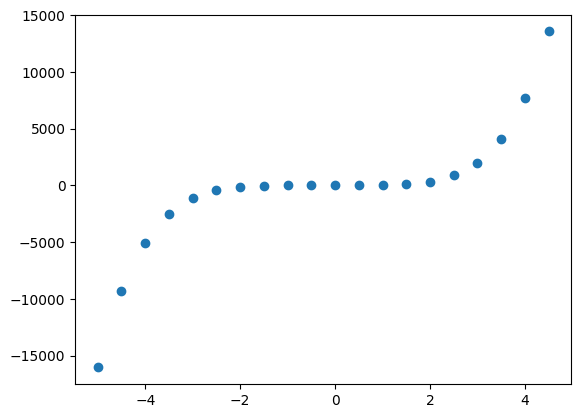

In [6]:
#@title Generate regression data
equation_form = "polynomial" #@param ["polynomial", "abs", "step"]

X_START = -5
X_END = 5
X_STEP = 0.5

def equation(x):
  if equation_form == "polynomial":
    return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10)
  elif equation_form == "abs":
    return abs(x)
  else:
    return np.where(x>1, 1, 0)

X = np.array([x for x in np.arange(X_START, X_END, X_STEP)])
Y = equation(X)
data = list(zip(X, Y))

plt.scatter(X,Y)

In [7]:
import csv
with open('data.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(data)

In [8]:
#@title Evaluation of fitness
def pred(ind, x):
  y_ = 0.0
  for i in range(1,NDIM):
    y_ += ind[i-1]*x**i
  y_ += ind[NDIM-1]
  return y_

def fitness(ind, data):
  mse = 0.0
  for x, y in data:
    y_ = pred(ind, x)
    mse += (y - y_)**2
  return mse/len(data),

# fitness eval
toolbox.register("evaluate", fitness, data=data)

In [9]:
#@title Plot Fitness
def plot_fitness(g, best, pop, logbook):
  Y_ = np.array([pred(best, x) for x in X])
  clear_output()
  print(f"Generation {g}, Best {best}")
  print(logbook.stream)
  fits = [f.fitness.values[0] for f in pop]
  plt.hist(fits)
  plt.show()
  plt.scatter(X,Y)
  plt.plot(X,Y_, 'r')
  plt.show()

Generation 74, Best Individual('d', [-3.167160568235027, 14.628624183306307, 6.518744932092441, 4.657203888666894, 5.922609248024759, -44.636440332082])
50 	300  	98072.1    	3884.67    	100740     	554922     
51 	300  	91758.4    	3884.67    	96301.4    	554922     
52 	300  	91368      	3884.67    	94136.6    	554922     
53 	300  	85262.4    	3884.67    	90204      	553886     
54 	300  	77932.6    	3884.67    	87098.8    	423874     
55 	300  	76516.8    	3884.67    	84202.9    	412051     
56 	300  	73910.4    	3884.67    	82149.8    	412051     
57 	300  	72754.9    	3884.67    	80339.9    	412051     
58 	300  	72474.4    	3884.67    	78503.8    	412051     
59 	300  	71924.1    	3884.67    	76012.6    	412051     
60 	300  	71554.4    	3884.67    	74592.9    	412051     
61 	300  	68091.9    	3884.67    	71477.6    	412051     
62 	300  	64250.4    	3884.67    	69395.4    	396297     
63 	300  	62392.1    	3884.67    	67546.6    	396297     
64 	300  	60344.9    	3320.43    	6

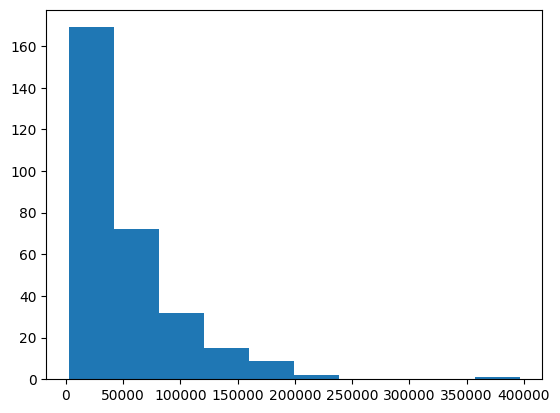

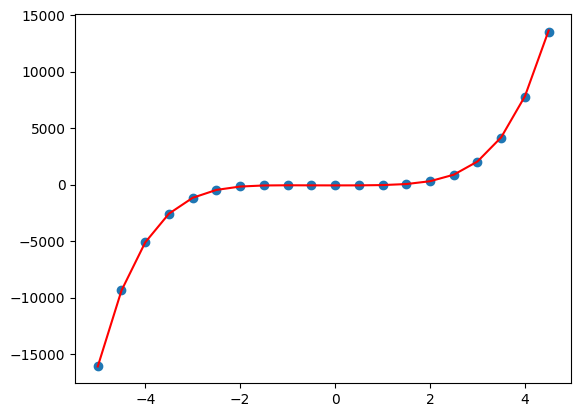

Best individual is  Individual('d', [-3.167160568235027, 14.628624183306307, 6.518744932092441, 4.657203888666894, 5.922609248024759, -44.636440332082]) 2460.4979045485916


In [10]:
pop = toolbox.population(n=MU);
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max"

# Evaluate the individuals
fitnesses = toolbox.map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

record = stats.compile(pop)
logbook.record(gen=0, evals=len(pop), **record)
print(logbook.stream)
start = time.time()
for g in range(1, NGEN):
  for k, agent in enumerate(pop):
    a,b,c = toolbox.select(pop)
    y = toolbox.clone(agent)
    index = random.randrange(NDIM)
    for i, value in enumerate(agent):
      if i == index or random.random() < CR:
        y[i] = a[i] + F*(b[i]-c[i])
    y.fitness.values = toolbox.evaluate(y)
    if y.fitness > agent.fitness:
      pop[k] = y
  hof.update(pop)
  record = stats.compile(pop)
  logbook.record(gen=g, evals=len(pop), **record)
  if (g+1) % GEN_OUTPUT == 0:
    plot_fitness(g, hof[0], pop, logbook)
    end = time.time()
    if end-start > MAX_TIME:
      break

print("Best individual is ", hof[0], hof[0].fitness.values[0])
